___
___
___


# **Datenanalyse & Forecasting Excercise 2024**

___
___
___



# **1. Introduction**

Welcome to our exercise notebook on data analysis and time series forecasting with pyWATTS! This notebook will explore some tools for analyzing data and further show a small pipline approach to forecast future values using pyWATTS. This notebook will provide you with some insights and hands-on experience in working with time series data. Therefore, let's get started and dive into the exciting world of data analysis and time series forecasting with pyWATTS!

Please note it is mandatory to install all the required software and packages using the guide provided in Ilias before proceeding with this exercise notebook. The guide contains important instructions how to properly set up your environment. This ensures that all the necessary dependencies are installed. Failure to follow the instructions may result in errors or unexpected behavior while working through the notebook.

This is an interactive notebook and also includes some work assignments. Typical tasks are adding lines of code, documenting observations. Work orders are always marked in the color <span style="color:#A00000"> **red** </span>. We suggest you work in pairs or small groups so that you can share observations and discuss the tasks together.


___

## Agenda 

1. Introduction, Agenda, learning goals and data loading

2. Data Analysis

3. Pywatts Excercise - Forecasting Pipeline and Steps

___


##  Learning goals (sorted by chapter) 

### Learning goals data analysis and time series analysis

    - Enumerate different properties of time series e.g. seasonality    
    - Analyze energy time series and recognize and evaluate seasonal patterns
    - Derive and design appropriate calendrical features by considering seasonality and autocorellation function.


### Learning goals machine learning
    - Name and evaluate various different steps within a machine learning process.
    - Be able to name the advantages of splitting data between training and test data.
    - Be able to name advantages and disadvantages of a pipline-based approach like pyWATTS.
     

___




## Data loading and first preprocessing
As a basis for the data analysis we need data in the first place. This publically available data set is described here: [Full Dataset Introduction](https://data.open-power-system-data.org/household_data/2020-04-15)

Here we have taken only a subset of the data, since we want to deal with only one building. Our choice is the industrial building 3. All the data is scaled in kWh. The building has an installed pv and an energy demand.



In [17]:
import warnings
import pandas as pd
import statsmodels.api as sm
import numpy as np
import pylab
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from IPython.display import Markdown as md

from sklearn.preprocessing import StandardScaler

from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode

from pywatts.modules import SKLearnWrapper
from pywatts.modules.preprocessing.select import Select
from pywatts.modules.wrappers import FunctionModule
from pywatts.modules.feature_extraction.calendar_extraction import CalendarExtraction, CalendarFeature
from pywatts.summaries import RMSE, MAE



# Basic configuration to get beautiful pictures 
pylab.rcParams['figure.figsize'] = (16, 9)

# Basic configuration to hide some of the annoying warnings that pyWATTS generates
warnings.filterwarnings('ignore')

# Load the data
date_parser = lambda date: pd.Timestamp(pd.to_datetime(date, format= '%Y-%m-%dT%H:%M:%SZ'))
data = pd.read_csv("data/household_data_15min_singleindex_filtered-2.csv", index_col="utc_timestamp", parse_dates=True ,date_parser=date_parser, sep=',')

# Get the relevant data for this excercise and resample it to hourly resolution to save runtime complexity
data["demand"] = data["DE_KN_industrial3_grid_import"].diff(1).resample("1h").mean()
data["solar"] = (data["DE_KN_industrial3_pv_facade"].diff(1) + data["DE_KN_industrial3_pv_roof"].diff(1)).resample("1h").mean()

# Omit data without values
data = data[["demand","solar"]].dropna()
# Let the data start with a full day and end with a full day
data =  data[(data.index >= pd.to_datetime("2016-11-03")) &  (data.index < pd.to_datetime("2017-06-04"))]

# **2. Data Analysis**

<img src="images/data_trap.png" width="400" height="400">

[This xkcd comic you can find here](https://xkcd.com/2582/)

Within the data analysis chapter, we will first use simple tools from Pandas to get an overview of the data set.
After that, we will make a daily observation of the load and analyse the difference between a weekday and weekend.
In the last part we will use more complex tools like autocorellation plots and a seasonal decomposition to identify properties like trend and seasonality in our time series.

First of all, we would like to show you three very simple functions that Pandas has ready for you :

## Warmup and get familiar with the data

1. head() First five rows of the data set. Commonly used as a sanity check to see how the Data is constructed. [API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)
2. describe() Provides basic satistical values of the dataset. For example, mean, standard deviation and quantiles.[API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
3. plot() The plot function draws a simple plot over all collumns of the given dataset with mathplolib. [API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

### <span style="color:#A00000"> Use the three functions (head, describe and plot) below! </span>



In [18]:
# Use the head function

data.head()

,demand,solar
utc_timestamp,,
2016-11-03 00:00:00,15.0000,0.0
2016-11-03 01:00:00,15.1875,0.0
2016-11-03 02:00:00,15.0000,0.0
2016-11-03 03:00:00,14.8125,0.0
2016-11-03 04:00:00,14.4375,0.0


In [19]:
# Use the describe function
data.describe()

,demand,solar
count,5112.000000,5112.000000
mean,19.426448,0.421909
std,8.721126,0.865757
min,7.187500,0.000000
25%,14.187500,0.000000
50%,14.875000,0.000000
75%,23.562500,0.337891
max,50.187500,4.289062


 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> Based on these broad statistic, what would you infer about the house considered? </span>
 - <span style="color:#A00000 "> Do these statistics help you to get a feel for the data and what it looks like? </span>
 - <span style="color:#A00000 "> Does this data seem realistic? </span>
 - <span style="color:#A00000 "> Do you see any challanges? </span>
 - <span style="color:#A00000 "> How much data do we have? </span>

< Space for your answers>


<Axes: xlabel='utc_timestamp'>

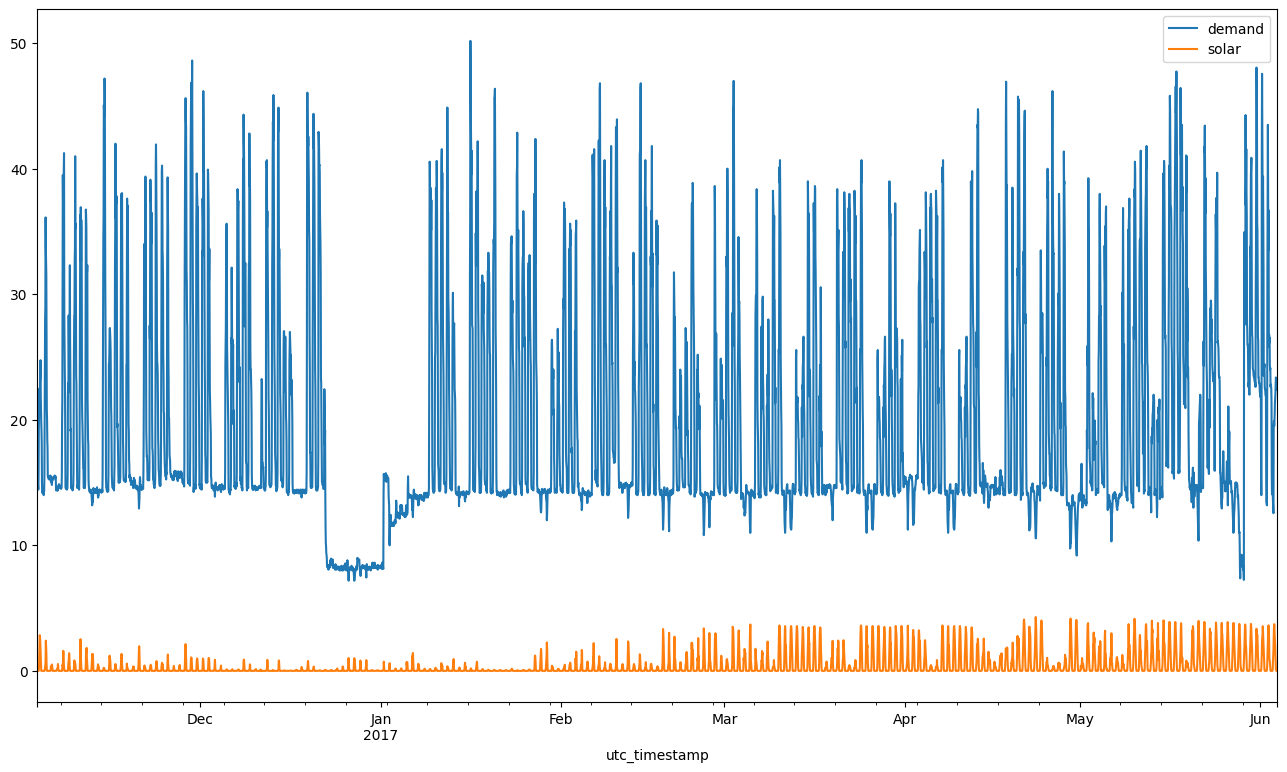

In [20]:
# Use the plot function
data.plot()

 ### <span style="color:#A00000 "> Point out two observations about the given data! </span>

1. < Observation 1 >
2. < Observation 2 >

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> What did you find more beneficial, the statistics of the plots? </span>
 - <span style="color:#A00000 "> Do you see a benefit in both statstics and plots or would you only consider one of them? </span>

< Space for your answers>


## Daily observations

This part first shows an example of the pivot table how it is used to plot the data on daily basis. Further it extends by using the month attribute to plot the months in different plots. As you can see differnt days of the month are plotted.

In [6]:
# Calculating the hour of the day the weekday and the day since the beginning of the time series to create the pivot table
data["hour"] = data.index.hour.values
data["weekday"] = data.index.weekday.values
data["month"] = data.index.month.values
data["days_since_start"] = [int(x/(24)) for x in range(0,len(data))]

# creates the pivot table to get a table with the days since start in the columns and hours of the day as rows. For later usage the months are taken into account as the value parameter.
pivot_solar = pd.pivot_table(data, index=['hour'],columns=['days_since_start'], values=['solar','month'])

pivot_solar["solar"]


days_since_start,0,1,2,3,4,5,6,7,8,9,...,203,204,205,206,207,208,209,210,211,212
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005859,0.005859,0.007812,0.007812,0.007812,0.006836,0.003906,0.000000,0.007812,0.009766
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.110352,0.128906,0.128906,0.143555,0.134766,0.147461,0.061523,0.022461,0.089844,0.147461
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.513672,0.677734,0.676758,0.652344,0.641602,0.635742,0.449219,0.211426,0.343750,0.679688
6,0.052734,0.013672,0.004883,0.005859,0.009766,0.038086,0.031250,0.007812,0.003906,0.007812,...,1.182129,1.281250,1.272461,1.245117,1.206543,1.287109,0.951172,0.717285,1.034668,1.263672
7,0.399902,0.154297,0.127930,0.022461,0.268066,0.367188,0.297852,0.193848,0.175293,0.143555,...,1.907227,1.838867,1.810059,1.787598,1.742188,1.820312,1.690918,1.381348,1.758789,1.764648
8,1.282227,0.380859,0.362793,0.101562,0.481934,0.622070,0.792969,0.936035,0.711914,0.447266,...,2.606445,2.643066,2.615723,2.532227,2.480469,2.520020,2.290527,2.377441,2.569824,2.535645


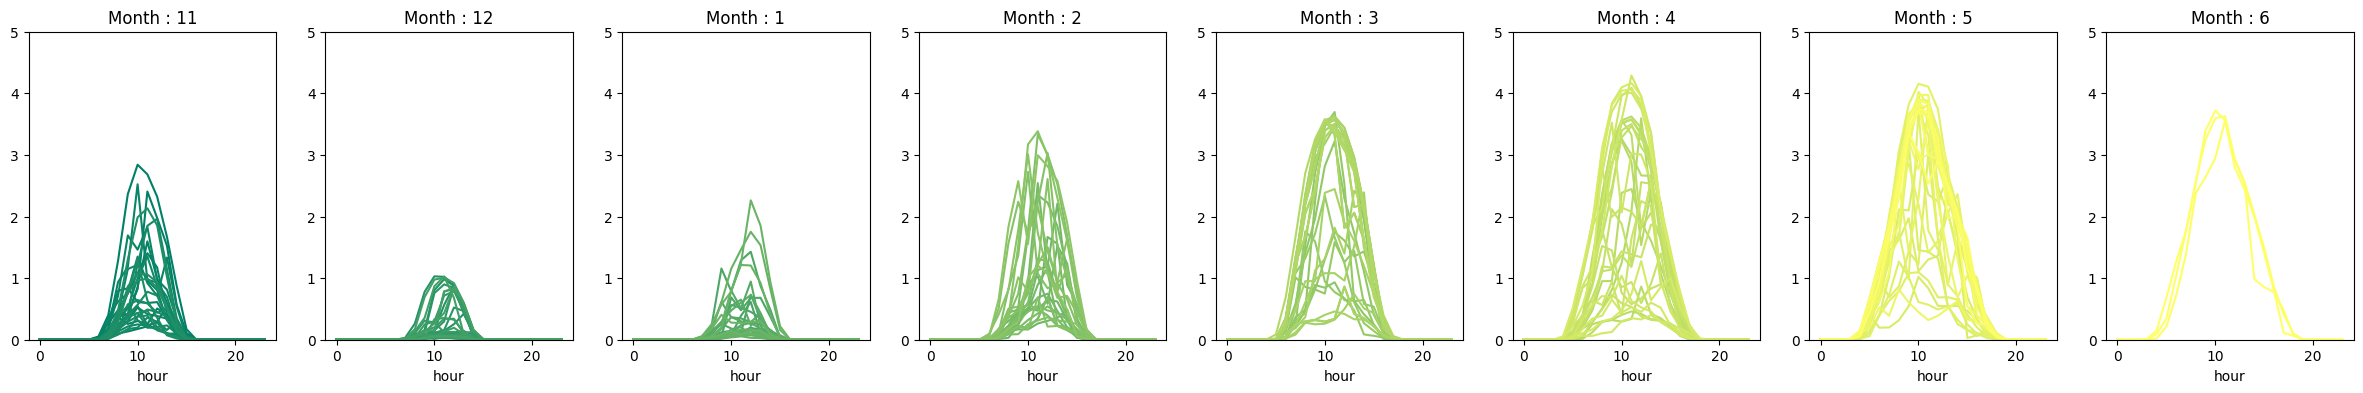

In [7]:
fig, ax = plt.subplots(1,len(data["month"].unique()))
for i in range(len(data["month"].unique())):
    pivot_solar[pivot_solar["month"]==data["month"].unique()[i]]["solar"].plot(ax=ax[i],figsize=(30, 4), layout= (7,1),ylim = (0,5),legend=False, colormap="summer", title="Month : " + str(data["month"].unique()[i]))

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> What do you observe during the different months ? </span>

### Workingdays

 ### <span style="color:#A00000 "> Plot only the working days (i.e. Monday-Friday):</span>
 - <span style="color:#A00000 ">The aim is to first filter the data to only get the days from Monday to Friday.</span>
 - <span style="color:#A00000 ">Create a variable ``working_day_data`` and use the weekday column in ``data`` to select the working days. The weekday column is enumerated from 0-6 with 0 being monday and 6 sunday. Therefore working days are the days with a weekday value smaller than five. You can select a column in pandas with ``data["column_name"]`` and if you want to select a subset of the data based on the value in this column you need to use the syntax ``data[data["column_name"] * x]``, where ``*`` indicates a mathematical operater such as ``<`` and ``x`` is the condition. For example, to only select Tuesday you would use ``tuesday_data = data[data["weekday"] == 1]``.</span>
 - <span style="color:#A00000 ">Create the pivot table similar to the example above using the function pivot_table from pandas! [API](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html). Make sure you use the filtered ``working_day_data`` variable created above.</span>
 - <span style="color:#A00000 ">Extend the pivot table to plot working days. Use "days_since_start" as ``columms``, "hour" as ``index`` and "demand" as ``values``!</span>

<Axes: xlabel='hour'>

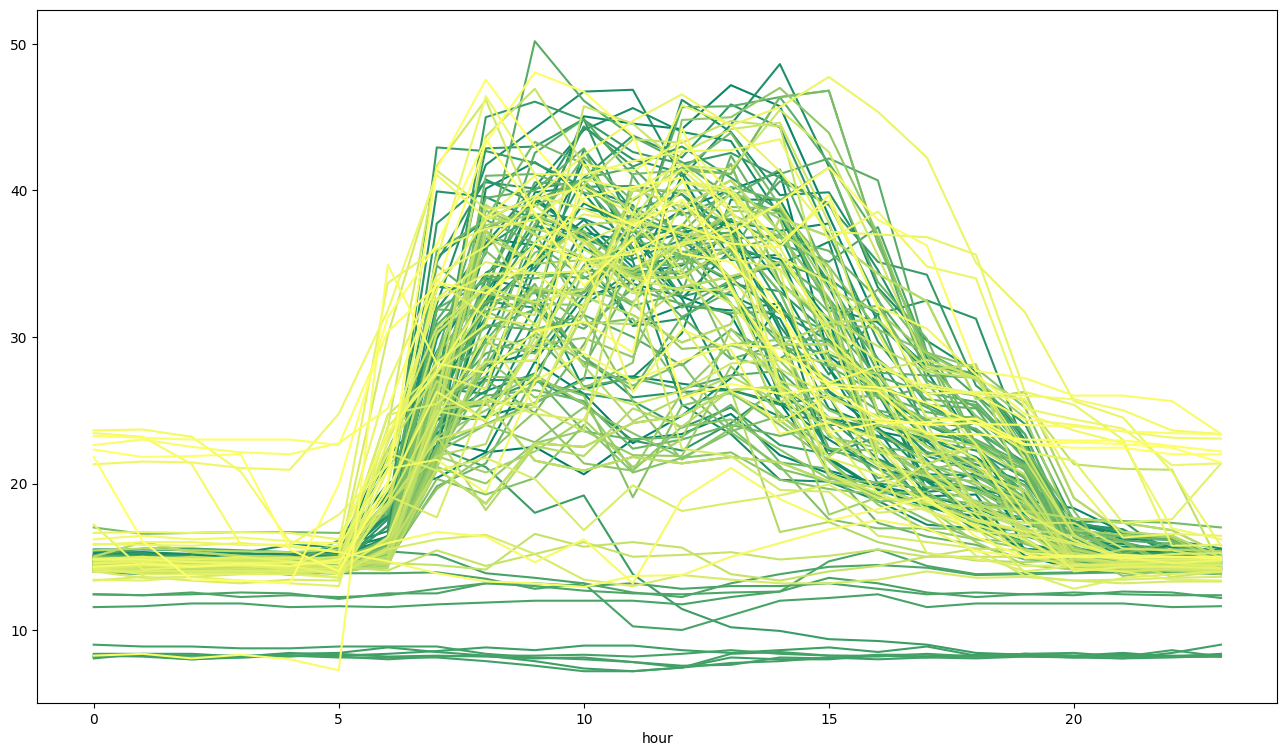

In [8]:

# this get's gapped
working_day_data = data[data["weekday"] < 5]
pivot_workingdays = pd.pivot_table(working_day_data, index=['hour'],columns=['days_since_start'], values=['demand'])

# plots the data
pivot_workingdays["demand"].plot(legend=False,colormap="summer")



### Weekend

 ### <span style="color:#A00000 "> Plot the weekends:</span>
 - <span style="color:#A00000 ">Repeat the task above, but this time only select the weekends (remember weekday is enumerated from 0-6, with 0 being Monday).</span>

<Axes: xlabel='hour'>

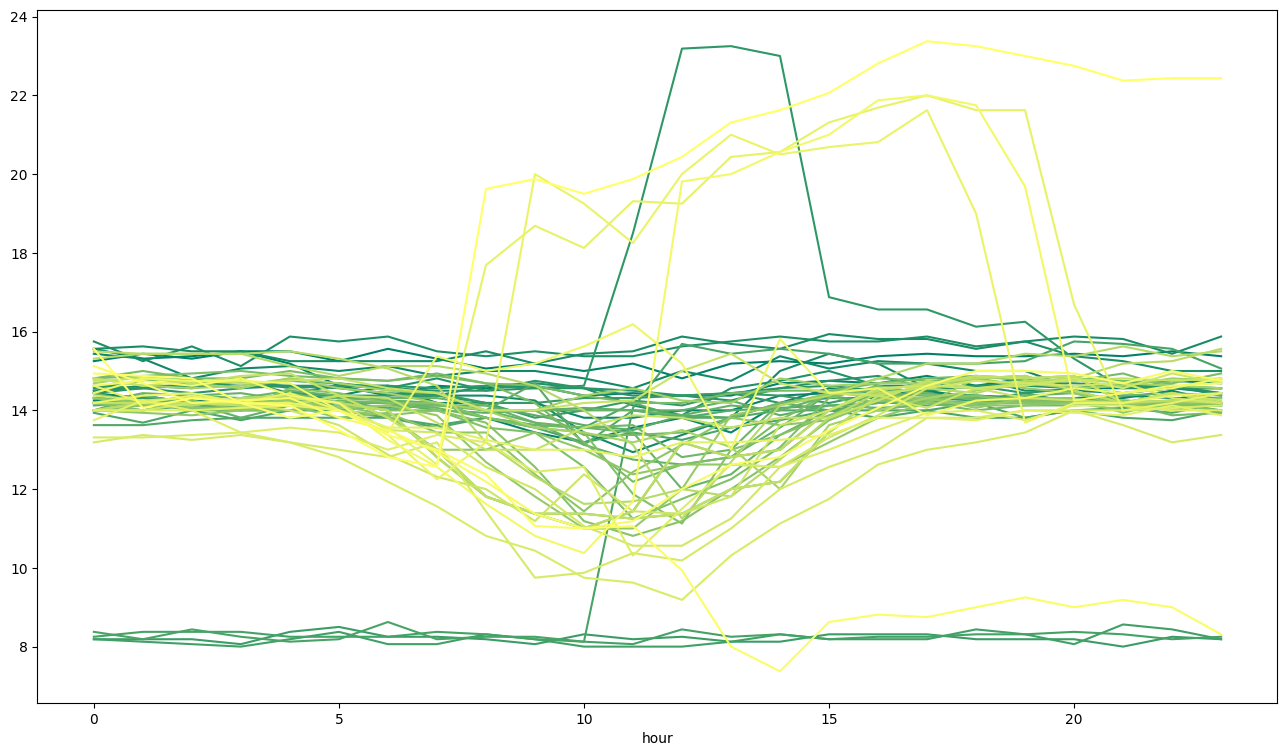

In [9]:

# this get's gapped
weekday_data = data[data["weekday"] >= 5]
pivot_weekends = pd.pivot_table(weekday_data, index=['hour'],columns=['days_since_start'], values=['demand'])
pivot_weekends["demand"].plot(legend=False,colormap="summer")


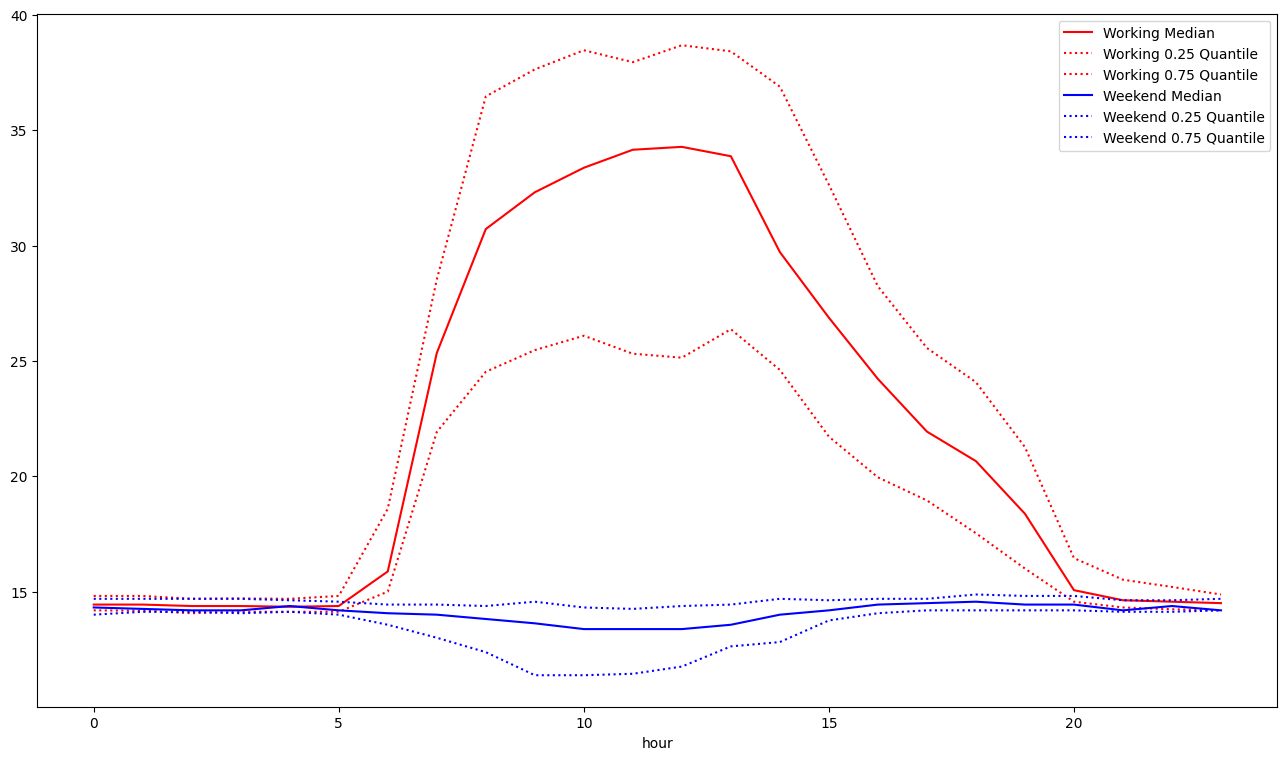

In [10]:
#
# Plot the median of all weekdays 
#

pivot_workingdays.median(axis=1).plot(color="red", label="Working Median")
pivot_workingdays.quantile(0.25,axis=1).plot(color="red",linestyle='dotted', label="Working 0.25 Quantile")
pivot_workingdays.quantile(0.75,axis=1).plot(color="red",linestyle='dotted', label="Working 0.75 Quantile")
pivot_weekends.median(axis=1).plot(color="blue", label="Weekend Median")
pivot_weekends.quantile(0.25,axis=1).plot(color="blue",linestyle='dotted', label="Weekend 0.25 Quantile")
pivot_weekends.quantile(0.75,axis=1).plot(color="blue",linestyle='dotted', label="Weekend 0.75 Quantile")
plt.legend()

 ### <span style="color:#A00000 "> Discuss in your group:</span>
 - <span style="color:#A00000 "> Do these different plots (weekdays, weekends, median) fit your expectations?</span>
 - <span style="color:#A00000 "> What could explain the pattern for this building for a weekday? </span>
 - <span style="color:#A00000 "> Could you interfer the base load of the building by looking at the daily observation plots? </span>
 - <span style="color:#A00000 "> How could explain the higher variance of weekdays in contrast to weekends? </span>
 - <span style="color:#A00000 "> Based on these observations, what features would you consider extracting or engineering for a forecasting task? </span>

< Space for your answers>


## Autorcorrelation Function and Seasonal Decomposition

### Autocorrelation Function Plot


The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. [Eexplanation from here](https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=The%20autocorrelation%20function%20(ACF)%20is,number%20of%20periods%20or%20units.)

An detailed expleantion is here: [Autocorrelation](https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/)

API-Statsmodels [API](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html)

### Seasonal Decomposition

An detailed explaination about the used seasonal decomposition can be found here: [API](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

The additive model which is used here is defined as $Y[t] = T[t] + S[t] + e[t]$.

The results are obtained by first estimating the trend by applying a convolugit stion filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

#### Demand ACF and Seasonal Decomposition

 ### <span style="color:#A00000 "> Play around with autocorrelation: </span>
- <span style="color:#A00000 "> Use the ``sm.tsa.graphics.plot_acf(x, lags=None)`` function to plot the autocorrelation function of ``data["demand"]``. </span>
- <span style="color:#A00000 "> Play around with a different number of lags, i.e. 5, 24, 200. </span>
- <span style="color:#A00000 "> What do you observe? </span>

In [ ]:
sm.tsa.graphics.plot_acf(data["demand"], lags= 200);

 ### <span style="color:#A00000 "> Play around with seasonal decomposition: </span>
- <span style="color:#A00000 "> Use the ``statsmodels.tsa.seasonal.seasonal_decompose(x, period=None)`` function to create a seasonal decomposition of ``data["demand"]``. </span>
- <span style="color:#A00000 "> Visualise this decomposition with ``sm.tsa.seasonal_decompose().plot()``. </span>
- <span style="color:#A00000 "> Adjust the ''period'' parameter of the function, try for example 24 (a day), or 168 (a week), or something random (e.g. 77). </span>
- <span style="color:#A00000 "> What do you observe? </span>

In [ ]:
# do seasonal decomposition of demand here 
# this get's gapped
sm.tsa.seasonal_decompose(data["demand"], period=24).plot();


### ACF and Seasonal Decomposition Solar

 ### <span style="color:#A00000 "> Repeat the above two tasks for the solar data! </span>

In [ ]:
# do seasonale decomposition on solar data (data["solar"])
# Gap here for acf
sm.tsa.graphics.plot_acf(data["solar"], lags= 200);

In [ ]:
# do seasonal decomposition of demand here 
# this get's gapped
sm.tsa.seasonal_decompose(data["solar"], period=24).plot();


# <span style="color:#A00000 ">  STOP HERE - We want to discuss some things together before going on </span>

# **3. pyWATTS Excercise - Forecasting Pipeline and Steps**

In this section of the Jupyter Notebook, you will learn about using pyWATTS to perform time series forecasting. Time series forecasting is a technique used to predict future values of a variable based on historical data and possible known exogenous variables. It can be useful in many fields, such as finance, economics, and engineering, but also in energy informatics.

But first of all what is pyWATTS:

## ChatGPT - What is pyWATTS?
### ChatGPT's Opinion

>pyWATTS is an open-source Python library designed to simplify time series analysis. It provides users with a range of powerful tools for exploring, visualizing, and modeling time series data. Pywatts is particularly useful for tasks such as forecasting, anomaly detection, and data preprocessing. The library includes a wide range of functionality, including a suite of built-in data loaders for importing time series data from a variety of sources, such as CSV files, databases, and web APIs. Pywatts also includes a range of data preprocessing tools, such as resampling, interpolation, and feature engineering, that can help users to prepare their time series data for analysis. One of the key features of Pywatts is its support for a range of machine learning models for time series analysis. These models include popular algorithms such as ARIMA, LSTM, and GRU models, as well as models for anomaly detection, such as isolation forests and one-class SVMs. Pywatts also provides tools for model training, evaluation, and deployment, making it an ideal platform for both research and production environments. Pywatts is designed to be easy to use, with a simple and intuitive interface that makes it accessible to users with a wide range of backgrounds and skill levels. The library is actively maintained and supported by a community of developers, ensuring that it is up-to-date and compatible with the latest versions of Python and other libraries. Overall, Pywatts is a powerful and flexible tool for anyone working with time series data. Whether you are a researcher, analyst, or data scientist, Pywatts can help you to quickly and easily preprocess, analyze, and model your time series data, enabling you to gain valuable insights and make informed decisions.

### Does ChatGPT actually know what it is talking about?

Honestly - No! But, (as is often the case with such models) ChatGPT did get a few things right (and it is surprising that pyWATTS is even known by ChatGPT).

#### Where did ChatGPT mess up?
 - pyWATTS doesn't have data loaders. You are responsible for loading the data yourself (from a csv, data bank, etc.) and then putting it into the pyWATTS pipeline.
 - Feature engineering doesn't really exist. We do have some tools (like a calendar extractor) but mostly you still have to create features yourself.
 - The time series tools and models mentioned are from other python packages - we have wrappers that allow sklearn, keras, and other packages to run within pyWATTS pipelines.
 - It is not a production environment and currently it doesn't have a large community of developers.
 - BUT - pyWATTS is currently being integrated into sktime and in the future the core pipeline functionality will be a native part of the sktime library!


#### Here our explanation what pyWATTS is:

The goals of pyWATTS (Python Workflow Automation Tool for Time-Series) are to support researchers in conducting automated time series experiments independent of the execution environment and to make methods developed during the research easily reusable for other researchers.
Therefore, pyWATTS is an automation tool for time series analysis that implements three core ideas:

- pyWATTS provides a pipeline to support the execution of experiments. This way, the execution of simple and often recurring tasks is simplified. For example, a defined preprocessing pipeline could be reused in other experiments. Furthermore, the execution of defined pipelines is independent of the execution environment. Consequently, for the repetition or reuse of a third-party experiment or pipeline, it should be sufficient to install pyWATTS and clone the third-party repository.
- pyWATTS allows to define end-to-end pipelines for experiments. Therefore, experiments can be easily executed that comprise the preprocessing, models and benchmark training, evaluation, and comparison of the models with the benchmark.
- pyWATTS defines an API that forces the different methods (called modules) to have the same interface in order to make newly developed methods more reusable.

For more Information and additional documentation: [pyWATTS documentation](https://pywatts.readthedocs.io/en/latest/)

## <span style="color:#A00000 ">  What do you think? </span>
- <span style="color:#A00000 ">  Why do you think we created pyWATTS? </span>
- <span style="color:#A00000 ">  Can you see any benefit in pyWATTS? </span>
- <span style="color:#A00000 "> Based on the description, would you be interested in working with pyWATTS? </span>

## Exercises

The exercises walk you through the creation of a pipeline for time series forecasting. The pipeline includes several steps, such as data preprocessing, model selection, and evaluation. By following the steps in the pipeline, you will learn how to create a forecast up to 24 hours ahead.

Now, let's look at what we prepared:

### Data
The data usage is visible in this figure:

<img src="images/24_hours_ahead_forecast_2.png" width="800" height="300">

### Metrics

To evaluate the accuracy of the forecast, the section provides various metrics, such as mean absolute error and root mean squared error. These metrics allow you to understand how close the forecasted values are to the actual values. Those metrics are introduced here:


MAE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})$


RMSE = $\sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2}$


### Models

Suggested models that are easy to use:

1. Random Forrest [Random Forrest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
2. Linear Regression [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
3. Simple Multi Layer Perceptron [MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)
4. XGBoost [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

###
To help with the interpretation of the results, the section includes visualizations of the forecasted values and actual values over time. These visualizations can help you identify trends and patterns that may not be immediately apparent from the metrics alone.

Overall, this section provides a practical introduction to using pyWatts for time series forecasting. By the end of the section, you will have a good understanding of the pipeline for time series forecasting and maybe see an advantage of those concepts.

## <span style="color:#A00000 ">  The piepeline: </span>
- <span style="color:#A00000 ">  What do the different steps of the pipeline do. Look at the code, comments, and the docs here : [API](https://github.com/KIT-IAI/pyWATTS) to help answer the question. </span>


In [12]:
def get_forecasting_pipeline(forecast_horizon, historical_time_steps, scope_var, forecasting_wrappers):
    #
    # Method which initializes a Pipeline with a given forecast horizon, a number of historical time steps to consider, a selected scope variable, and a list of forecasting Wrappers
    #


    # initializes the pipeline and selects where the results are saved
    forecast_pipeline = Pipeline(f"results/")

    # builds up calendar features with public holidays and sinus and cos encoded hours, weekdays, month and holidays. 
    calendar = CalendarExtraction('calendar',continent="Europe", country="Germany",
                                           features=[CalendarFeature.month_sine, CalendarFeature.month_cos,
                                                    CalendarFeature.weekday_sine, CalendarFeature.weekday_cos,
                                                    CalendarFeature.workday, CalendarFeature.holiday, CalendarFeature.hour_cos, CalendarFeature.hour_sine])(x=forecast_pipeline[scope_var])

    # data scaling especially useful for neural network approaches
    data_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler")
    data_scaled = data_scaler(x=forecast_pipeline[scope_var])

    # Selects the data in samples from t=-24 up to t=0 for the history, and t=0 up to t=24 for target and calendar features
    features_scaled = Select(start=-historical_time_steps, stop=0, step=1, name="Sample_historical_features")(x=data_scaled)
    target_scaled = Select(start=0, stop=forecast_horizon, step=1, name="Sample_targets")(x=data_scaled)
    calendar_selected = Select(start=0, stop=forecast_horizon, step=1, name="Sample_calendar")(x=calendar)

    # dict for the forecasts scaled and unscaled as there are different forecasters are used
    result_dict= {}
    result_dict_unscaled = {}
    target = data_scaler(x=target_scaled, computation_mode=ComputationMode.Transform, method="inverse_transform")
    FunctionModule(lambda x:x, name='target')(x=target)
    

    # doing everything same for the different forecasters
    for forecaster in forecasting_wrappers:
        result_dict[forecaster.name] = forecaster(
        features=features_scaled,
        calendar=calendar_selected,
        target=target_scaled,
        )

        result_dict_unscaled[forecaster.name] = data_scaler(x=result_dict[forecaster.name], computation_mode=ComputationMode.Transform,method="inverse_transform")
        FunctionModule(lambda x:x, name='forecast_' + forecaster.name)(x=result_dict_unscaled[forecaster.name])
        
        # Evaluation on RMSE and MAE
        RMSE(name="rmse_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)
        MAE(name="mae_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)

    return forecast_pipeline

## <span style="color:#A00000 ">  Discuss in your group: </span>
- <span style="color:#A00000 ">  Which elements that we discussed in the Menti occur in this pipeline? </span>
- <span style="color:#A00000 ">  What aspects of the pipeline could be changed? What aspects would you change? </span>
- <span style="color:#A00000 ">  What are the input sizes and the feature sizes? </span>

 ### <span style="color:#A00000 "> Lets think about the pipeline: </span>

- <span style="color:#A00000 "> Read through the code below and make sure you understand what is happening. </span>
- <span style="color:#A00000 "> Then run it, and we can look at the plot that is created. </span>



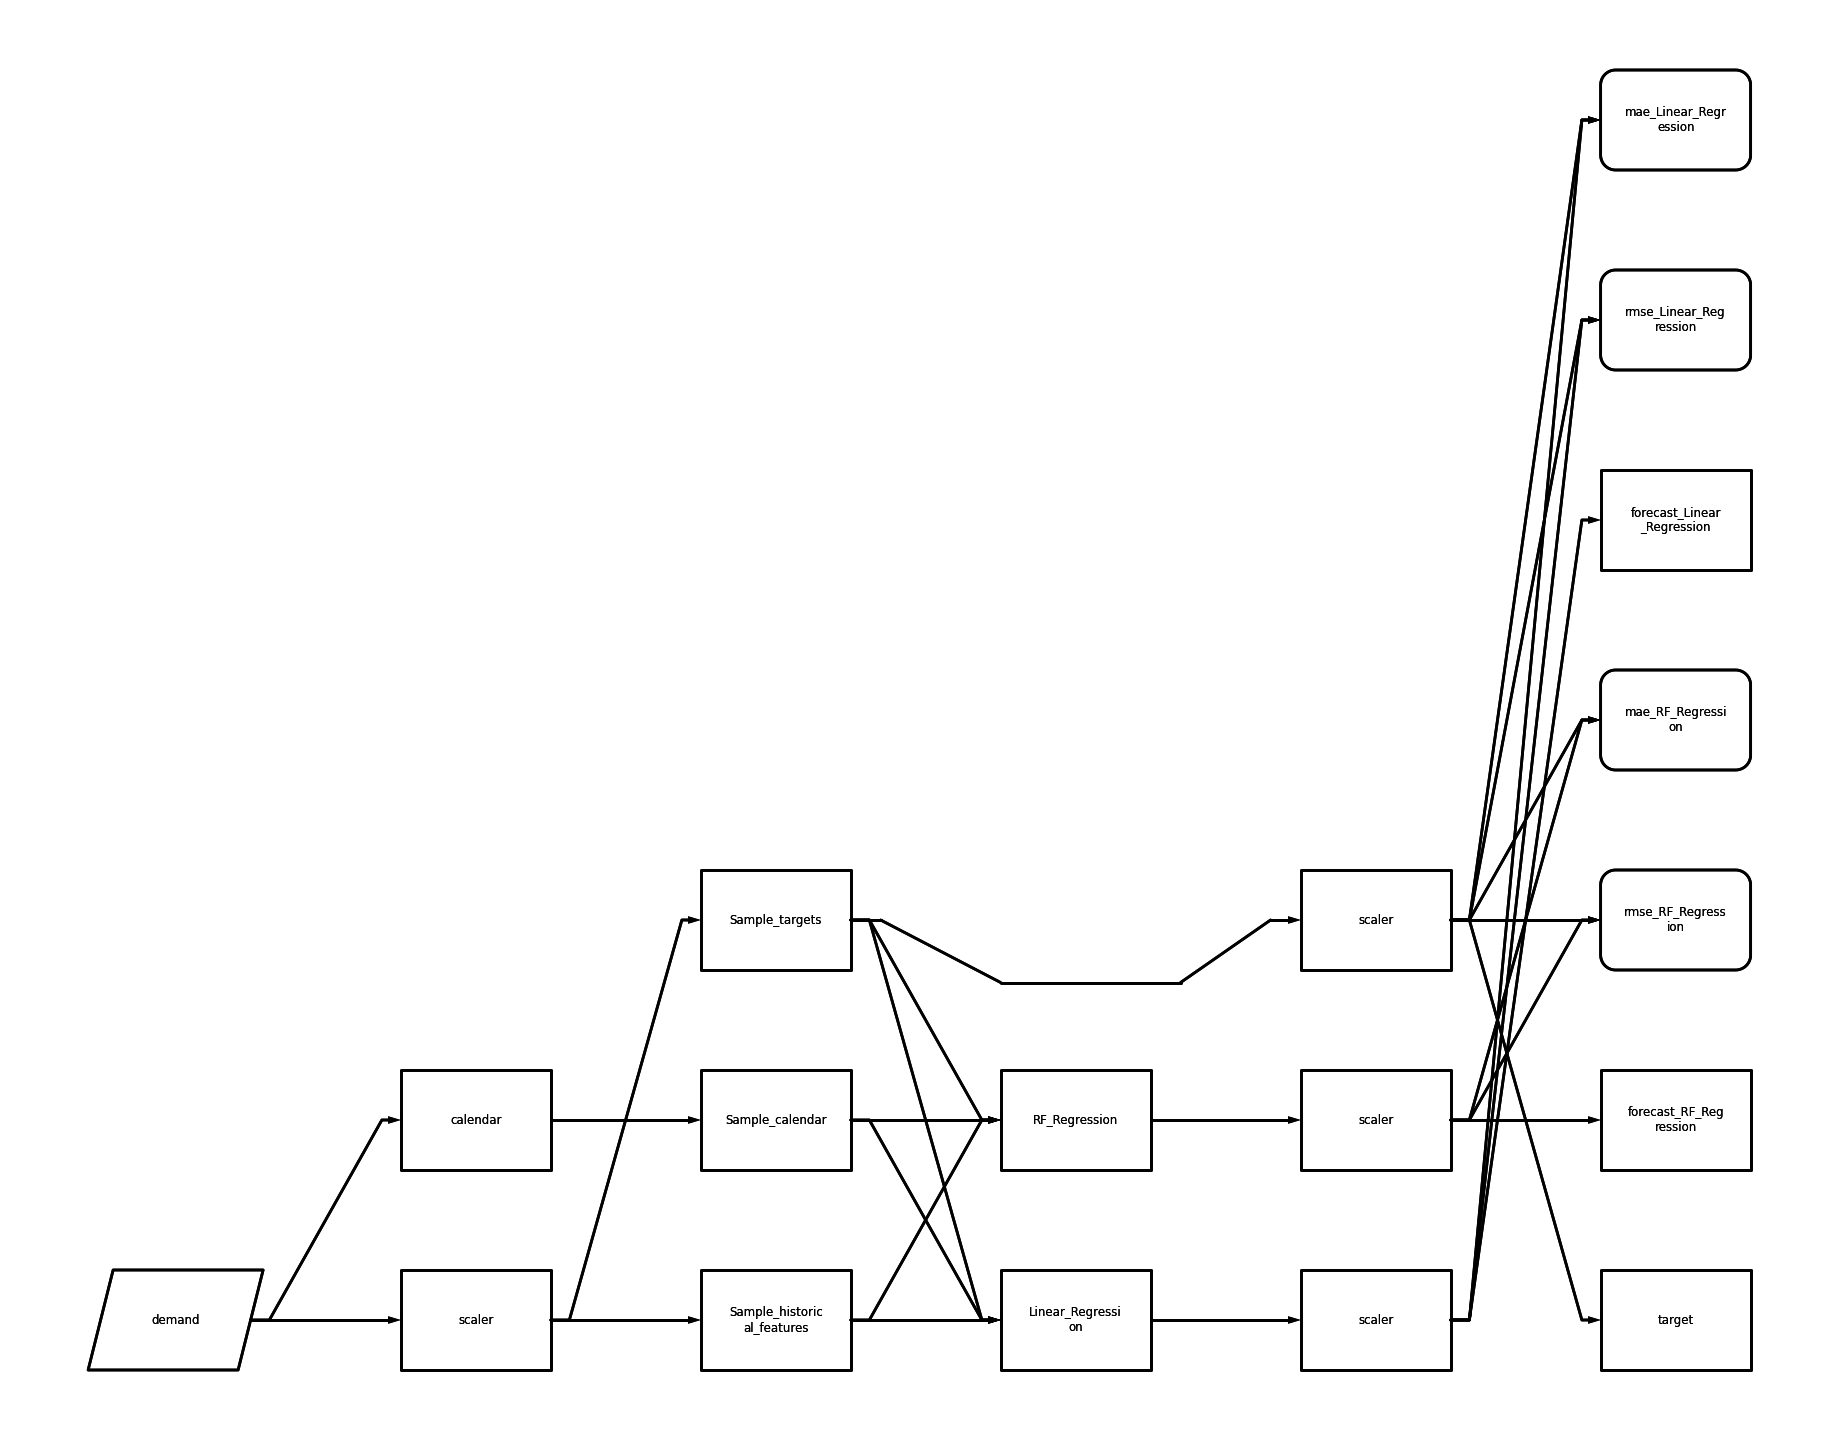

In [16]:
#Select which variable is going to be forecast
SCOPE_VARIABLE =  ["demand"]

#Decide a time index to use to split the training and test data sets.
TRAINING_END = pd.Timestamp("2017-03-01")

# Here we define the forecasters used. This is a list that includes a random forest regressor and a linear regressor.
forecasters = [ SKLearnWrapper(module=RandomForestRegressor(), name="RF_Regression"),
                SKLearnWrapper(module=LinearRegression(), name="Linear_Regression")
                ]

# Here we split the data into a training and test set
training_data = data[SCOPE_VARIABLE][:TRAINING_END]
testing_data = data[SCOPE_VARIABLE][TRAINING_END:]


# Now we create the pipeline using the previously defined "get_forecasting_pipeline()" function
# At the moment we use 24h of historical features, create a forecast for 24h ahead and
# forecast demand using the two forecasters defined in the list above
pipeline = get_forecasting_pipeline(forecast_horizon=24,
                                    historical_time_steps=24,
                                    scope_var="demand",
                                    forecasting_wrappers=forecasters)

# Now the pipeline is created we can draw it to understand what is happening
drawing = pipeline.draw()
drawing.draw()

### <span style="color:#A00000 "> Discuss in your group: </span>
- <span style="color:#A00000 "> Does the visulisation meet your expectations based on how you understood the code?. </span>
- <span style="color:#A00000 "> What is helpful about the visualisation? What is confusing?. </span>

### <span style="color:#A00000 "> Now, lets create some results: </span>
- <span style="color:#A00000 "> Read through the code below and then run it to train and test the pipeline. </span>

In [23]:

# pipeline.train() trains the pipeline using the training data
res_train , summary_train  = pipeline.train(training_data)

# pipeline.test() on evaluates the pipeline on the test data
res_test , summary_test  = pipeline.test(testing_data)

# Result Visualisation

The basic functionality to access the metrics in pyWATTS is called Summary. They get saved in the result files, in the result folder generated.

### <span style="color:#A00000 "> Together with your group: </span>
- <span style="color:#A00000 "> Use the ``md()`` function on ``summary_test`` and ``summary_train``. </span>
- <span style="color:#A00000 "> What metrics are logged here?</span>
- <span style="color:#A00000 "> What do you observe?</span>
- <span style="color:#A00000 "> How different are the used metrics in training vs testing? </span>
- <span style="color:#A00000 "> Can you explain these differences and observations?. </span>

In [24]:
# Use the md() function on both of the summaries
md(summary_test)

# Summary: 
## Summary
### rmse_RF_Regression

* y_hat : 4.689524331490438
### mae_RF_Regression

* y_hat : 2.8306431907007705
### rmse_Linear_Regression

* y_hat : 5.11180244353557
### mae_Linear_Regression

* y_hat : 3.8894950415507155
## FitTime
### calendar Training Time

*  : 9.5367431640625e-07
### scaler Training Time

*  : 0.0006330013275146484
### Sample_historical_features Training Time

*  : 9.5367431640625e-07
### Sample_targets Training Time

*  : 4.76837158203125e-06
### Sample_calendar Training Time

*  : 9.5367431640625e-07
### target Training Time

*  : 1.6689300537109375e-06
### RF_Regression Training Time

*  : 8.381729125976562
### forecast_RF_Regression Training Time

*  : 1.9073486328125e-06
### Linear_Regression Training Time

*  : 0.07962703704833984
### forecast_Linear_Regression Training Time

*  : 2.1457672119140625e-06
## TransformTime
### calendar Transform Time

*  : 0.03418588638305664
### scaler Transform Time

*  : 0.0003650188446044922
### Sample_historical_features Transform Time

*  : 0.037271976470947266
### Sample_targets Transform Time

*  : 0.01006007194519043
### Sample_calendar Transform Time

*  : 0.011426210403442383
### scaler Transform Time

*  : 0.0003650188446044922
### target Transform Time

*  : 2.1457672119140625e-06
### RF_Regression Transform Time

*  : 0.027551889419555664
### scaler Transform Time

*  : 0.00037980079650878906
### forecast_RF_Regression Transform Time

*  : 5.9604644775390625e-06
### Linear_Regression Transform Time

*  : 0.00286102294921875
### scaler Transform Time

*  : 0.00034165382385253906
### forecast_Linear_Regression Transform Time

*  : 1.9073486328125e-06


Now we are going to visualise the data...

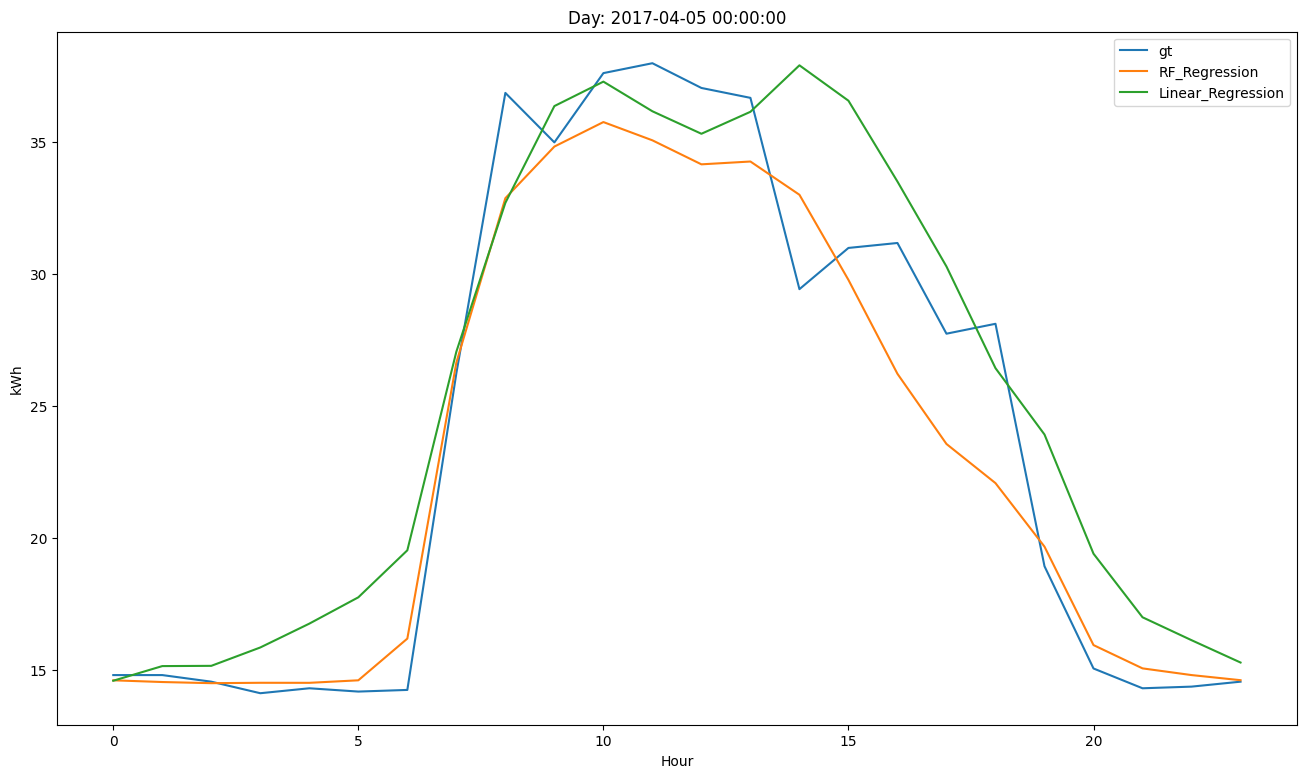

In [26]:
# Some plots

gt = res_test["target"]
day = pd.Timestamp("2017-04-05")
gt_day = gt.sel(utc_timestamp =day).values
plt.title("Day: " + str(day))
plt.xlabel("Hour")
plt.ylabel("kWh")
x = np.arange(0,24)
plt.plot(x, gt_day, label="gt" )

for forecaster in forecasters:
    forecast = res_test["forecast_" + forecaster.name].sel(utc_timestamp =day).values
    plt.plot(x, forecast, label=forecaster.name)

plt.legend()
plt.show()

### <span style="color:#A00000 "> Discuss with your group: </span>
- <span style="color:#A00000 "> Do the plots help with the evaluation?. </span>
- <span style="color:#A00000 "> What are the advantages of a plot compared to metrics?</span>
- <span style="color:#A00000 "> What are the disadvantages of a plot compared to metrics?</span>

## <span style="color:#A00000 "> Now you can play! </span>
- <span style="color:#A00000 "> Go back to where you filled out the pipeline and try including different forecasting methods such as xgboost.</span>
- <span style="color:#A00000 "> Play around with the forecast horizon and the number of historical features.</span>
- <span style="color:#A00000 "> You can also try altering the scope variable being forecast.</span>
- <span style="color:#A00000 "> How do the results change?</span>
- <span style="color:#A00000 "> Which forecasters perform best?</span>
- <span style="color:#A00000 "> How quantity is the easiest to forecast?</span>
<span style="color:#A00000 ">Feel free to spend time discussing the results in your group and if you have questions don't hesitate to ask!</span>

# Some Further Links
If you've got this far, then feel free to check out some more in depth stuff with pyWATTS:
- [Anomaly Detection using pyWATTS](https://github.com/KIT-IAI/EnhancingAnomalyDetectionMethods)
- Repository with advanced pyWATTS Examples: [pyWATTS deRSE 2023](https://github.com/KIT-IAI/pyWATTS-deRSE-2023)



<img src="images/machine_learning.png" width="600" height="800">

[This xkcd comic you can find here](https://xkcd.com/1838/)